# FC base net

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset

import ipdb

In [2]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
seed = 25
setup_seed(seed)

In [3]:
def mape_loss_func(preds, labels):
    mask = labels > 5
    return np.mean(np.fabs(labels[mask]-preds[mask])/labels[mask])

def smape_loss_func(preds, labels):
    mask= labels > 5
    return np.mean(2*np.fabs(labels[mask]-preds[mask])/(np.fabs(labels[mask])+np.fabs(preds[mask])))

def mae_loss_func(preds, labels):
    mask= labels > 5
    return np.fabs((labels[mask]-preds[mask])).mean()

def eliminate_nan(b):
    a = np.array(b)
    c = a[~np.isnan(a)]
    return c

# Load data

In [4]:
def norm_data(vec):
    vec = vec.flatten()
    return (vec - min(vec))/(max(vec) - min(vec)), min(vec), max(vec)

In [5]:
randseed = seed
res = 11

v = pd.read_csv('../data/v_20_aggragated.csv')
v = v.rename(columns={'Unnamed: 0': 'id'})
det_with_class = pd.read_csv('../res/%i_res%i_id_402_withclass.csv'%(randseed, res), index_col=0)

v['class_i'] = ''
for i in range(len(v)):
    v.loc[i, 'class_i'] = det_with_class[det_with_class['id']==v.loc[i, 'id']].iloc[0, 5]  # 5 stands for 'class_i'

num_class = det_with_class['class_i'].drop_duplicates().size

v_class = []
for i in range(num_class):
    v_class.append(v[v['class_i']==i])

print('There are %i class(es)'%num_class)

dist_mat = pd.read_csv('../data/dist_mat.csv', index_col=0)
id_info = pd.read_csv('../data/id2000.csv', index_col=0)
dist_mat.index = id_info['id2']
dist_mat.columns = id_info['id2']
for i in range(len(dist_mat)):
    for j in range(len(dist_mat)):
        if i==j:
            dist_mat.iloc[i, j] = 0

near_id = pd.DataFrame(np.argsort(np.array(dist_mat)), index = id_info['id2'], columns = id_info['id2'])

def get_node(det, seg):
    # det is one single detector id
    # node is one single node id
    
    # seg = pd.read_csv('./data/segement.csv', header=None)
    try:
        node_info = seg[seg[6]==det]
        node = node_info.iloc[0, 0]
    except:
        node_info = seg[seg[7]==det]
        node = node_info.iloc[0, 0]
        
    return node

def get_class_with_node(seg, v_class):
    det_list_class = np.array([])
    try:
        v_class.insert(1, 'id2', '')  # id2 mean node id
    except:
        v_class['id2'] = ''
        
    for i in range(len(v_class)):
        det_list_class = np.append(det_list_class, v_class.iloc[i, 0])
        v_class.iloc[i, 1] = get_node(v_class.iloc[i, 0], seg)
    
    return det_list_class, v_class

def rds_mat(old_dist_mat, det_ids):
    # get a matrix that contains n raods that have specified node id s
    node_ids = np.array([])
    for i in det_ids:
        node_ids = np.append(node_ids, get_node(i, seg))
        
    new_dist_mat = old_dist_mat.loc[node_ids, node_ids]
    old_dist_mat = np.array(old_dist_mat)
    new_near_id_mat = np.argsort(new_dist_mat)
    return new_near_id_mat

seg = pd.read_csv('../data/segement.csv', header=None)
num_dets = 30

det_list_class = []
for i in range(num_class):
    det_list_class_temp, v_class_temp = get_class_with_node(seg, v_class[i])
    det_list_class.append(det_list_class_temp)
    v_class_temp = v_class_temp[v_class_temp['id'].isin(det_list_class_temp[:num_dets])]
    v_class[i] = v_class_temp

near_road_set = []
for i in range(num_class):
    near_road_set.append(rds_mat(dist_mat, det_list_class[i][:num_dets]))



There are 5 class(es)


C:\Users\10169\.conda\envs\dan_traff\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [6]:
src_flow, src_min, src_max = norm_data(np.array(v_class[0].iloc[:, 4466-144*10-1:4466-144*7-1], dtype=float))
# in this case, only target data is accessible
tar_flow, tar_min, tar_max = norm_data(np.array(v_class[1].iloc[:, 4466-144*10-1:4466-144-1], dtype=float))

# Data assembling

In [7]:
def sliding_window(data, window_size, prop):
    pred_samp = 3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # "data" should be 1-D vector
    data = data.flatten()
    data_out = []
    label_out = []
    for i in range(data.shape[0] - window_size - pred_samp):
        data_out.append(data[i : i + window_size])
        label_out.append(data[i + window_size + 1: i + window_size + 1 + pred_samp])  # to predict the next 3 flows
    data_out = np.array(data_out)
    label_out = np.array(label_out)
    
    train_data_out = torch.tensor(data_out[:int(data_out.shape[0]*prop), :], dtype=torch.float32).to(device)
    train_label_out = torch.tensor(label_out[:int(data_out.shape[0]*prop)], dtype=torch.float32).to(device)
    val_data_out = torch.tensor(data_out[int(data_out.shape[0]*prop):, :], dtype=torch.float32).to(device)
    val_label_out = torch.tensor(label_out[int(data_out.shape[0]*prop):], dtype=torch.float32).to(device)
    
    return train_data_out, train_label_out, val_data_out, val_label_out

In [8]:
window_size = 10
batch_size = 57600
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
src_train_data, src_train_label, _, _ = sliding_window(src_flow, window_size, 1)
tar_train_data, tar_train_label, tar_val_data, tar_val_label = sliding_window(tar_flow, window_size, 0.3)

src_train_loader = torch.utils.data.DataLoader(
    TensorDataset(src_train_data, src_train_label), batch_size, shuffle=True
)
tar_train_loader = torch.utils.data.DataLoader(
    TensorDataset(tar_train_data, tar_train_label), batch_size, shuffle=True
)

src_iter, tar_iter = iter(src_train_loader), iter(tar_train_loader)

In [9]:
print(tar_train_data.shape)
print(tar_train_label.shape)
print(tar_val_data.shape)
print(tar_val_label.shape)

torch.Size([11660, 10])
torch.Size([11660, 3])
torch.Size([27207, 10])
torch.Size([27207, 3])


# FC network (base)

In [10]:
class traffic_base_net(nn.Module):
    def __init__(self, inp_dim, out_dim, hid_dim):
        super(traffic_base_net, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(inp_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim*2),
            nn.ReLU(),
            nn.Linear(hid_dim*2, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim),
            nn.ReLU(),
        )  # regression
    
    def forward(self, x):
        # input size: (batchsize, seq_len, input_dim)
        # output size: (batchsize, seq_len, hid_dim)
#         ipdb.set_trace()
        # y = self.lstm(x)[0]  # y, (h, c) = self.rnn(x)
        
        y = self.fc(x)[:, -3:]  # fully connected layer
        
        return y

# Training on target data

In [11]:
inp_dim = window_size
out_dim = 1
hid_dim = 8
# layers = 3

In [12]:
traff_node_base = traffic_base_net(inp_dim, out_dim, hid_dim).to(device)

loss_func = nn.MSELoss()
val_loss_set = []
train_loss_set = []

#summary(traff_node_dannet, input_size=(batch_size, window_size), device=device)

In [13]:
optimizer = optim.Adam(traff_node_base.parameters())

In [14]:
traff_node_base.train()

epochs = 300

# assert len(src_loader) == len(tar_loader)
   
for e in range(epochs):
    #ipdb.set_trace()
    for i in range(len(src_train_loader)):
        try:
            tar_data, tar_label = tar_iter.next()
        except:
            tar_iter = iter(tar_train_loader)
            tar_data, tar_label = tar_iter.next()
        
        tar_out = traff_node_base(tar_data)
        #ipdb.set_trace()
        loss = loss_func(tar_out, tar_label)  # target dataset loss

        val_out = traff_node_base(tar_val_data)
        val_loss = loss_func(val_out, tar_val_label)
        #ipdb.set_trace()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        val_loss_set.append(val_loss.cpu().detach().numpy())
        train_loss_set.append(loss.cpu().detach().numpy())
    if e%50==0:
        print('Epoch %i success, val loss:%.5f, train loss:%.5f'%(e, val_loss.cpu().detach().numpy(), loss.cpu().detach().numpy()))

C:\Users\10169\.conda\envs\dan_traff\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([11660, 3])) that is different to the input size (torch.Size([11660, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\10169\.conda\envs\dan_traff\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([27207, 3])) that is different to the input size (torch.Size([27207, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 success, val loss:0.33206, train loss:0.27889
Epoch 50 success, val loss:0.09282, train loss:0.07554
Epoch 100 success, val loss:0.01982, train loss:0.02670
Epoch 150 success, val loss:0.01888, train loss:0.02436
Epoch 200 success, val loss:0.01640, train loss:0.02134
Epoch 250 success, val loss:0.01375, train loss:0.01802


In [15]:
torch.save(traff_node_base.state_dict(), '../model/base_FC.h5')
torch.cuda.empty_cache()

# Visualization

In [16]:
def plot_loss(val, train, title):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.plot(val)
    ax1.set_xlabel('Batches')
    ax1.set_ylabel('MSELoss')
    ax1.set_ylim([0, max(val)])
    ax1.set_title('Validation loss')
    ax1.grid()
    ax2 = fig.add_subplot(122)
    ax2.plot(train)
    ax2.set_xlabel('Batches')
    ax2.set_ylabel('MSELoss')
    ax2.set_ylim([0, max(train)])
    ax2.set_title('Train loss')
    ax2.grid()
    plt.suptitle(title)

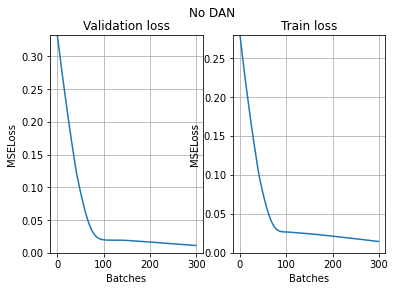

In [17]:
plot_loss(val_loss_set, train_loss_set, 'No DAN')

Text(0.5, 1.0, 'Target dataset')

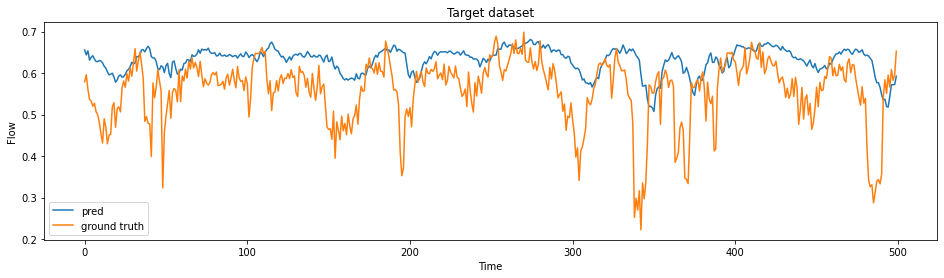

In [18]:
plt.figure(figsize=[16,4])
plt.plot(val_out[:500, -1].cpu().detach().numpy(), label='pred')
plt.plot(tar_val_label[:500, -1].cpu().detach().numpy(), label='ground truth')
plt.legend()
plt.xlabel('Time')  # time gran: 15 min
plt.ylabel('Flow')
plt.title('Target dataset')

# Evaluation

In [19]:
def mape_loss_func(preds, labels):
    #ipdb.set_trace()
    try:
        preds = preds.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
    except:
        preds = preds.detach().numpy()
        labels = labels.detach().numpy()
        
    mask = labels > 5
    return np.mean(np.fabs(labels[mask]-preds[mask])/labels[mask])

def smape_loss_func(preds, labels):
    try:
        preds = preds.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
    except:
        preds = preds.detach().numpy()
        labels = labels.detach().numpy()
        
    mask= labels > 5
    return np.mean(2*np.fabs(labels[mask]-preds[mask])/(np.fabs(labels[mask])+np.fabs(preds[mask])))

def mae_loss_func(preds, labels):
    try:
        preds = preds.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
    except:
        preds = preds.detach().numpy()
        labels = labels.detach().numpy()
        
    mask= labels > 5
    return np.fabs((labels[mask]-preds[mask])).mean()

def eliminate_nan(b):
    a = np.array(b)
    c = a[~np.isnan(a)]
    return c

In [20]:
def denorm_data(vec, min_val, max_val):
    return vec*(max_val - min_val) + min_val

In [21]:
# traff_node_dannet = torch.load('./model/traff_node_dannet.pth')
traff_node_base.eval()

val_out = traff_node_base(tar_val_data)
val_out_denormed = denorm_data(val_out, tar_min, tar_max)
tar_val_label_denormed = denorm_data(tar_val_label, tar_min, tar_max)

print('MAPE: %.5f'%mape_loss_func(val_out_denormed[:, -1], tar_val_label_denormed[:, -1]))
print('SMAPE: %.5f'%smape_loss_func(val_out_denormed[:, -1], tar_val_label_denormed[:, -1]))
print('MAE: %.5f'%mae_loss_func(val_out_denormed[:, -1], tar_val_label_denormed[:, -1]))


MAPE: 0.11910
SMAPE: 0.11118
MAE: 7.11747


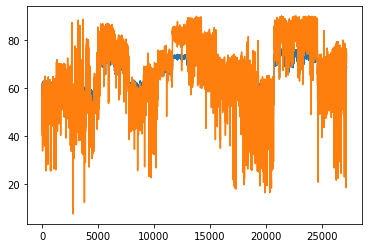

In [22]:
plt.plot(val_out_denormed[:, -1].cpu().detach().numpy())
plt.plot(tar_val_label_denormed[:, -1].cpu().detach().numpy())